# Classification of information using TensorFlow

### Recognizing handwritten digits using convolutional neural networks

<div align="right"><h3>Miroslav Semerád</h3></div>
<div align="right"><h4>Miroslav_Semerad@swissre.com</h4></div>
<div align="right"><h4>@mldeveloper</h4></div>

## About this workshop:

#### - Introduction to the digit classification problem
#### - MNIST - dataset of handwritten digits
#### - Simple detection using softmax regression
#### - Increasing the accuracy by implementing a convolutional neural network
#### - Integration of our model into a web app

## Introduction to the digit classification problem

- In our business we have a bunch of scanned documents with hand written digits (e.g. dates, amounts, prices).
- We want to automatically extract those numbers and use them to categorize our document.
- OCR technologies work great for printed text - not so well for handwritten text.
- We want to build a simple classifier that will read those numbers from a scan (image).
- It is a good introduction to the topic of classification using TensorFlow.

![detection](images/detection.png?arg)




### MNIST - dataset of handwritten digits

- Available on the Web and free to use.
- Contains 60000 images of handwritten digits from 0 to 9.
- Images are grayscale (1 color channel) with a resolution of 28 x 28 pixels.
- Images are flattened into an array of 784 float numbers - one number per pixel.    
- The dataset is split into training (55000) a test (5000) subset.
- The dataset is labelled - each image contains the correct label. 

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### An example from the dataset

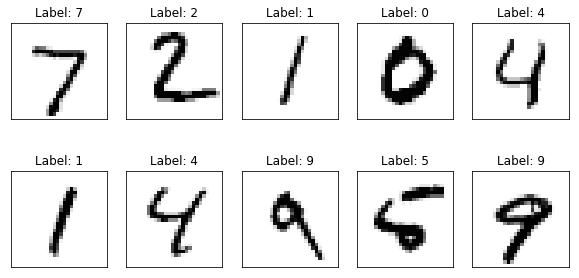

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    example = mnist.test.images[i]
    example_label = "Label: %s"%[a for a,b in enumerate(mnist.test.labels[i]) if b == 1][0]
    plt.title(example_label)
    plt.imshow(example.reshape([28,28]), cmap = cm.Greys)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()


#code hiding
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">Show code</a>.''')

### How do we use this dataset?

We will train our model on this dataset - we'll use the images and the labels.

Then we'll use our trained model to classify new data.

![training](images/training.png?arg)

## Simple classifier using softmax regression

Let's start with a simple regression model to build our first classifier.

We will use softmax regression for this task.

But first let's import TensorFlow and create a session.

### TensorFlow InteractiveSession

- TensorFlow is a library for numerical calculations developed by the Google Brain team.
- Currently it has been open sourced and is one of the most popular projects on Github.
- It's build on the data flow graph principle.
- All calculation operations are stored in a graph to be executed later.
- To execute an operation we have to create a TensorFlow session.
- InteractiveSession is an abstraction of the Session - simplyfies the usage of the API.

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()
print("Version: %s"%tf.__version__)

### Placeholders - entry points to our model

To be able to feed the model with external data we need to define our placeholder variables.

- **x**  image arrays of 784 elements from the MNIST dataset
- **y_** correct labels from the MNIST dataset   

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

### Model variables

These are local variables of the model. 

We will not be changing them.

The model does change them when it is trained.

- **W** - weights - is a matrix of weights, with the dimension of 784 x 10 (pixel x digit)
- **b** - bias - population parameter, some digits are less present than others in the dataset. Bias captures these differences and moves the slope to get correct prediction not based on the amounts of a digit in the training data.

In [ ]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

### Variable initialization

Befor training we have to initialize our variables to zeros.

In [ ]:
sess.run(tf.global_variables_initializer())

### Linear model (Score function)

We will define the following linear model:

### y = x*W + b
  

In [ ]:
y = tf.add(tf.matmul(x,W), b)

### Softmax cost function

The cost function calculates the differences between our predicted labels and the real labels from MNIST.

The goal is to minimize the cost.

Softmax is basically a normalized exponential function.

Cross entropy - function to calculate "unnatural" probability distribution.

- **tf.nn.softmax_cross_entropy_with_logits** - handy function built into TensorFlow
- **tf.reduce_mean** - arithmetic mean from all the categories

In [ ]:
import numpy as np
npa = np.array
def softmax(w, t = 3.0):
    e = np.exp(npa(w) / t)
    dist = e / np.sum(e)
    return dist

arr = np.arange(-10., 10., 0.2)
sig = softmax(arr)

plt.plot(arr, sig)
plt.ylabel('softmax')
plt.show()

#code hiding
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">Show code</a>.''')

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))

### Training of the model

The optimizer is an algorithm, that minimizes our cost function by adjusting the Weight (W) and bias (b) variables.

Gradient descent - is an iterative algorithm that calculates the steepest descent towards the minimum and then adjusts the values according to the step ratio.

- We will use the built-in **GradientDescentOptimizer** with the step size of 0.5.
- We will train in batches of 100 images.

In [ ]:
# define functions to measure accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# we will store accuracies in a list
acc_steps = []

# define our train step using the Gradient Descent Optimizer
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# training iterations
for i in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    if i%10==0:        
        acc_steps.append(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
    
# visualize accuracy
plt.plot(acc_steps)
plt.ylabel('accuracy')
plt.show()

In [ ]:
print("Accuracy %.f"%((acc_steps[-1])*100))

### Visualize the weights

In [ ]:
fig = plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = sess.run(W)[:,i]
    plt.title(i)
    plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('seismic'))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()

#code hiding
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">Show code</a>.''')

### How do we increase the accuracy?

- The accuracy of ~91% is pretty bad for MNIST.
- We can get a lot of bad predictions.
- To increase the accuracy we need a more complex model.
- A model that is capable to learn more complex patterns from the images.
- We will use a ConvNet for this purpose.
- But what is a ConvNet?

## Convolutional Neural Network

A neural network is a programmatic model, based on the principle of biological neurons.

The elemental part is a neuron - a small model with inputs and outputs (synapses).

The neuron does our predefinded calculation and passes it to other neurons.

ConvNets are a special kind of neural network which mimic the functionality of animal visual cortex.

They are based on the principle of convolution, grouping of cetrain neurons that identify certain patterns.

ConvNet's perform very well when used for recognizing objects from images or videos.


### Our network architecture

#### INPUT -> CONV -> RELU -> POOL -> CONV -> RELU -> POOL -> FC -> SOFTMAX -> OUTPUT

- CONV - convolutional layer
- RELU - activation function
- POOL - max pooling - subsampling
- FC - fully connected layer
- SOFTMAX - softmax regression

### Helper functions

Let's define some helper functions to help us build our convolutional network.

In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1,28,28,1])

### First CONV layer

- detects 32 features for each 5x5 patch.
- these layers are not densely connected - they are grouped to neighbouring regions

Our weights have the dimesion of [5, 5, 1, 32], that is:
- width of the patch
- height of the patch
- number of color channels - in our case inputs
- number of output channels - note that we will get a 3D output

![conv](images/conv.png?arg)


In [ ]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

### We will use the ReLU function as our activation function

Rectified Linear unit - it's definition is quite simple.

Everything below zero becomes zero.

### f(x) = max(0,x)

In [ ]:
import numpy as np
npa = np.array
def relu(a):
    return a.clip(min=0)

arr = np.arange(-10., 10., 0.2)
sig = relu(arr)

plt.plot(arr, sig)
plt.ylabel('ReLU')
plt.show()

#code hiding
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">Show code</a>.''')

### Max Pooling (subsampling)

None linear downsampling.

We take each 2x2 patch of the image and pick the highest value.


### Changes the resolution form 28x28 to 14x14

![pool](images/max_pool.png?arg)

In [ ]:
h_conv1 = tf.nn.relu(tf.add(conv2d(x_image, W_conv1), b_conv1))
h_pool1 = max_pool_2x2(h_conv1)

### Second CONV layer

- Similar to the first one
- 5x5 patch
- 32 inputs per region
- 64 outputs per region

### Max Pooling again lowers the resolution to 7x7

In [ ]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(tf.add(conv2d(h_pool1, W_conv2), b_conv2))
h_pool2 = max_pool_2x2(h_conv2)

### Fully connected layer

Standard in most classical neural networks.

Connects each neuron from all the regions together.

This enables us to detect patterns everywhere on the image not just in the specific region.

We'll get 1024 outputs.

![fc](images/FCLayer.png?arg)

### In the end we will reshape our matrix to a 1D vector with 196 values. 

In [ ]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_pool2_flat, W_fc1), b_fc1))

### Dropout

Dropout helps us to reduce overfitting.

Overfiting means that our model is too bound to our training data and performs badly on new test data.

Dropout is a simple technique of throwing out a random output from a neuron.

TensorFlow applies the Dropout automatically based on our specified keep_prob value.

We'll use it **only for training!**

In [ ]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### SOFTMAX layer

Now we will apply our softmax regression to the output of the previous layer to predict the labels.

In [ ]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))

### Training our model

<font color='red'><b>Warning: This could take several minutes on a standard PC.</b></font>

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

acc_steps = []

for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
        acc_steps.append(train_accuracy)
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

# visualize accuracy
plt.plot(acc_steps)
plt.ylabel('accuracy')
plt.show()

The accuracy is now about **99,2%**

### Example of classifing another image

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

index = 100

tmp = mnist.test.images[index]
tmp = tmp.reshape((28,28))

plt.imshow(tmp, cmap = cm.Greys, interpolation="nearest")
plt.show()

print("Label: %s"%[a for a,b in enumerate(mnist.test.labels[index]) if b == 1])

prediction=tf.argmax(y_conv,1)
print("Predicted Digit: %s"%prediction.eval(feed_dict={x: [mnist.test.images[index]], keep_prob: 1.0}, session=sess))

### Visualize the Activations

In [ ]:
import numpy as np
import math

def getActivations(activation,example):
    units = sess.run(activation,feed_dict={x:[example],keep_prob:1.0})
    plotNNFilter(units)

def plotNNFilter(units):
    filters = units.shape[2]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap=plt.get_cmap('coolwarm'))
    plt.show()
    
example_index = index
example = mnist.test.images[example_index]
example_label = "'MNIST example: Number %s"%[a for a,b in enumerate(mnist.test.labels[example_index]) if b == 1][0]

#code hiding
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">Show code</a>.''')

### Convolutional Layer 1

In [ ]:
getActivations(h_conv1,example)

### Max Pooling Layer 1

In [ ]:
getActivations(h_pool1,example)

### Convolutional Layer 2

In [ ]:
getActivations(h_conv2,example)

### Max Pooling Layer 2

In [ ]:
getActivations(h_pool2,example)

### Saving and restoring the model

Saving the model:

In [ ]:
saver = tf.train.Saver()
saver.save(sess, '/home/s8xcm9/models/')

Restoring the model:

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('/home/s8xcm9/models/'))

#### Contacts:



<div align="center">
<h1 style="color:blue;">Miroslav Semerád</h1>
<h2>@mldeveloper</h2>
<h2>Miroslav_Semerad@swissre.com</h2>
</div>